In [32]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [33]:
model = load_vgg_model("C:\\Users\\G50\\ml jupyter notebooks\\neural style\\imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable_1:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu_16:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_17:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool_5:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_18:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_19:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_6:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_20:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_21:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_22:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_23:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_7:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_24:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 

c:\users\g50\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


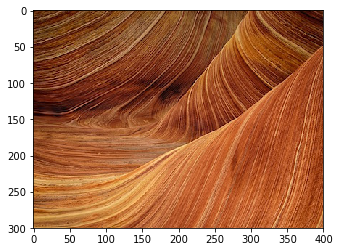

In [34]:
content_image = scipy.misc.imread("images/sandstone.jpg")
imshow(content_image)

In [35]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G 
    a_C_unrolled = tf.transpose(tf.reshape(a_C,[n_H*n_W,n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,[n_H*n_W,n_C]))
    
    # compute the cost with tensorflow 
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled))) / (4 * n_H * n_W * n_C)
    
    return J_content

In [36]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.7655935


c:\users\g50\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


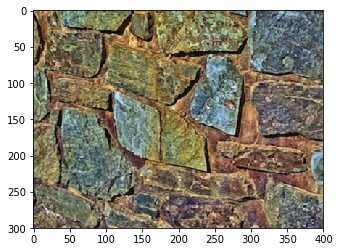

In [37]:
style_image = scipy.misc.imread("images/stone_style.jpg")
imshow(style_image)

In [38]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    import numpy as np
    GA = tf.matmul(A,tf.transpose(A))
    
    return GA

In [39]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


In [40]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) 
    a_S =  tf.transpose(tf.reshape(a_S,[n_H*n_W,n_C]))
    a_G =  tf.transpose(tf.reshape(a_G,[n_H*n_W,n_C]))

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square(GS-GG))/(4*n_C*n_C*n_H*n_H*n_W*n_W)
    
    return J_style_layer

In [41]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190278


In [42]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [43]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [44]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J =alpha *J_content+beta*J_style
    
    return J

In [45]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [46]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [47]:
content_image = scipy.misc.imread("images/sandstone.jpg")
content_image = reshape_and_normalize_image(content_image)

c:\users\g50\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [48]:
style_image = scipy.misc.imread("images/stone_style.jpg")
style_image = reshape_and_normalize_image(style_image)

c:\users\g50\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


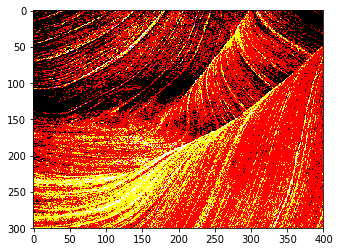

In [49]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [50]:
model = load_vgg_model("C:\\Users\\G50\\ml jupyter notebooks\\neural style\\imagenet-vgg-verydeep-19.mat")

In [51]:
sess.run(model['input'].assign(content_image))
# Select the output tensor of layer conv4_2
out = model['conv4_2']
# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)
# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out
# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [52]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [53]:
J = total_cost(J_content,J_style,alpha=10,beta=40)

In [54]:
# define optimizer 
optimizer = tf.train.AdamOptimizer(2.0)
# define train_step
train_step = optimizer.minimize(J)

In [55]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())

    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))

    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        
        _ = sess.run(train_step)
        
        
        # Compute the generated image by running the session on the current model['input']
        generated_image =sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("C:\\Users\\G50\\ml jupyter notebooks\\neural style\\output\\" + str(i)+"test2" + ".png", generated_image)
    
    # save last generated image
    save_image('C:\\Users\\G50\\ml jupyter notebooks\\neural style\\output\\generated_image2.jpg', generated_image)
    
    return generated_image
    

In [56]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 2428764000.0
content cost = 9577.876
style cost = 60716704.0
Iteration 20 :
total cost = 191367570.0
content cost = 19105.861
style cost = 4779413.0
Iteration 40 :
total cost = 66939276.0
content cost = 20544.287
style cost = 1668345.8
Iteration 60 :
total cost = 35370260.0
content cost = 21021.275
style cost = 879001.2
Iteration 80 :
total cost = 23654578.0
content cost = 21297.492
style cost = 586040.1
Iteration 100 :
total cost = 17431128.0
content cost = 21467.95
style cost = 430411.22
Iteration 120 :
total cost = 13496062.0
content cost = 21600.139
style cost = 332001.53
Iteration 140 :
total cost = 10836609.0
content cost = 21718.775
style cost = 265485.53
Iteration 160 :
total cost = 8963120.0
content cost = 21822.434
style cost = 218622.39
Iteration 180 :
total cost = 7597984.0
content cost = 21913.408
style cost = 184471.25


array([[[[ 2.6094452e+01, -8.3516998e+00,  7.4758997e+00],
         [ 2.9455112e+01, -5.8191433e+01, -3.6902554e+01],
         [-1.7002926e+01, -6.2791214e+01, -5.6158615e+01],
         ...,
         [-1.6492529e+01,  2.4299149e+01, -6.3398137e+00],
         [-4.0567299e+01,  2.5175299e+01, -9.4807854e+00],
         [-5.7565620e+01,  4.2771423e+01, -1.9216034e+01]],

        [[ 2.6910854e+01, -3.3370430e+01,  1.3238390e+01],
         [-6.8588058e+01, -5.5147583e+01, -7.7344696e+01],
         [-1.0638340e+02, -6.8994476e+01, -7.5997528e+01],
         ...,
         [-6.3685543e+01,  1.2857565e+01, -7.8244824e+00],
         [-4.9366207e+01,  3.4146574e+00, -3.1261837e+01],
         [-3.7342731e+01,  2.1723742e+01, -1.4887134e+01]],

        [[ 1.0617379e+01, -1.7041798e+01,  1.1906212e+01],
         [-8.1062393e+01, -6.9198982e+01, -7.8819778e+01],
         [-1.2397749e+02, -6.6065147e+01, -7.5303185e+01],
         ...,
         [-7.8181061e+01, -2.2582541e+01, -7.8153882e+00],
         [